In [1]:
import pandas as pd
#import xml.etree.ElementTree as ET
#import csv
import re, os, nltk
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from lxml import etree

In [2]:
os.chdir("/home/ubuntu/data")

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
def first(parent, expr):
    children = parent.xpath(expr)
    return children[0].text if len(children) > 0 else ''

def process_xml(file):
    root = etree.parse(file).getroot()
    global raw_docs, iteration,mesh_d_text,mesh_q_text
    iteration = 0
    mesh_d_text,mesh_q_text = '',''
    raw_docs = pd.DataFrame([['']*5]*len(root.getchildren()), columns = ['PMID','Title','Abstract','MeSH_Descriptor','MeSH_Qualifier'])
    
    for pmarticle in root.getchildren():
        
        pmid = first(pmarticle,'MedlineCitation/PMID')
        title = first(pmarticle, 'MedlineCitation/Article/ArticleTitle')
        asbtract = first(pmarticle,'MedlineCitation/Article/Abstract/AbstractText')
        
        mesh_d_text,mesh_q_text = '',''
    
        for heading in pmarticle.xpath('MedlineCitation/MeshHeadingList/MeshHeading'):
            MeSH_D = first(heading,'DescriptorName')
            mesh_d_text = mesh_d_text + "$" + MeSH_D
            
            MeSH_Q = first(heading,'QualifierName')
            mesh_q_text = mesh_q_text + "$" + MeSH_Q
        
        MeSH_D = mesh_d_text.split("$")
        MeSH_Q = mesh_q_text.split("$")
        
        raw_docs['PMID'][iteration] = pmid
        raw_docs['Title'][iteration] = title
        raw_docs['Abstract'][iteration] = asbtract
        raw_docs['MeSH_Descriptor'][iteration] = MeSH_D
        raw_docs['MeSH_Qualifier'][iteration] = MeSH_Q
        
        iteration += 1
    
    return(raw_docs)
    
# =============================================================================
# =============================================================================
# =============================================================================
# =============================================================================

stemmer = SnowballStemmer("english")
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list = stopword_list + ['']

def tokenize_text(txt):
    tokens = nltk.word_tokenize(txt)
    tokens = [token.strip() for token in tokens]
    return tokens

def clean(doc,remove_stopwords=True):
    #tokenize text
    doc=doc.replace('-', ' ')
    doc_text=tokenize_text(doc)  
    doc_text=[x.strip() for x in doc_text]
    
    # keep only text characters
    doc_text= [re.sub("[^a-zA-Z]","", word) for word in doc_text]
    
    # lower text and remove stop words
    words = [word.lower() for word in doc_text]
    if remove_stopwords:
        words = [w for w in words if not w in stopword_list]

    # stem words and re join 
    stems = [stemmer.stem(t) for t in words if t]
    stems = ' '.join(stems)

    return(stems)


In [5]:
#add new field
docs = process_xml('10000urine.xml')
docs['Total_Text'] = docs['Title'] + ' ' + docs['Abstract']

In [6]:
Cleaned_Doc_List=[] # creates matrix / variable

for line in docs['Total_Text']:
    Cleanedline=clean(line, True) #runs methods for each abstract in Doc_List
    Cleaned_Doc_List.append(Cleanedline) #creates new matrix of Cleaned_Doc_List
    
Clean_Text = pd.DataFrame(np.array(Cleaned_Doc_List), columns = ['Clean_Text'])

docs = pd.concat([docs, Clean_Text], axis=1)


In [47]:
docs.head(5)

,PMID,Title,Abstract,MeSH_Descriptor,MeSH_Qualifier,Total_Text,Clean_Text
0,61535,Acid-base diagrams.,,"[, Acid-Base Equilibrium, Acidosis, Humans, Me...","[, , diagnosis, , ]",Acid-base diagrams.,acid base diagram
1,61536,Immunising against receptors for antigen.,,"[, Animals, Antibodies, Neoplasm, Antigen-Anti...","[, , , , , , , , , immunology]",Immunising against receptors for antigen.,immunis receptor antigen
2,61537,Immune complexes in rheumatic disease.,,"[, Antigen-Antibody Complex, Arthritis, Rheuma...","[, , immunology, , , immunology]",Immune complexes in rheumatic disease.,immun complex rheumat diseas
3,61538,Loss of HLA antigens associated with hormonal ...,,"[, Adult, Female, Gonadal Steroid Hormones, HL...","[, , , , , , , , immunology, , , ]",Loss of HLA antigens associated with hormonal ...,loss hla antigen associ hormon state
4,61539,Hypocalcaemia after thyroidectomy.,,"[, Bone and Bones, Humans, Hyperthyroidism, Hy...","[, metabolism, , metabolism, etiology, adverse...",Hypocalcaemia after thyroidectomy.,hypocalcaemia thyroidectomi


# Insert Gout data

In [7]:
gout300=process_xml('300GoutGeneticsTreatementArticles.xml')
gout300['Total_Text'] = gout300['Title'] + ' ' + gout300['Abstract']
clean_gout=[]
for line in gout300['Total_Text']:
    Cleanedline=clean(line, True) #runs methods for each abstract in Doc_List
    clean_gout.append(Cleanedline) #creates new matrix of Cleaned_Doc_List
    
clean_gout_df = pd.DataFrame(np.array(clean_gout), columns = ['Clean_Text'])

gout300 = pd.concat([gout300, clean_gout_df], axis=1)

In [25]:
#checking to make sure things look right
gout300.head()
len(docs)
len(gout300)


383

In [8]:
# concatenate the dataframes
frames=[docs,gout300]
all_docs=pd.concat(frames)

In [ ]:
all_docs.columns

In [56]:
#how many do not have abstracts?
all_docs['Abstract'].isnull().sum()

0

In [27]:
len(all_docs)

30383

# List the PMID for Gout

In [9]:
pmid_list=['26810134','25676789','27798726','20962433','26086348']

# split the data into training and test

In [10]:
all_docs=all_docs.set_index('PMID')

In [11]:
#drop duplicates
all_docs=all_docs[~all_docs.index.duplicated(keep='first')]

In [12]:
all_docs.head(5)

,Title,Abstract,MeSH_Descriptor,MeSH_Qualifier,Total_Text,Clean_Text
PMID,,,,,,
26908487,Longitudinal Kinetics of Cytomegalovirus-Speci...,Congenital cytomegalovirus (CMV) is reported t...,"[, CD4-Positive T-Lymphocytes, CD8-Positive T-...","[, immunology, immunology, , immunology, conge...",Longitudinal Kinetics of Cytomegalovirus-Speci...,longitudin kinet cytomegalovirus specif cell i...
26663686,Effect of Sacral Neuromodulation on Outcome Me...,Sacral neuromodulation (SNM) may improve inter...,"[, Adolescent, Adult, Aged, Aged, 80 and over,...","[, , , , , urine, urine, therapy, methods, , ,...",Effect of Sacral Neuromodulation on Outcome Me...,effect sacral neuromodul outcom measur urin ch...
26638465,[DEFINITION OF INTERRELATION BETWEEN AMINOACID...,Age and sexual indexies of densitometry at pat...,"[, Adolescent, Amino Acids, Bone Density, Cher...","[, , urine, , , , deficiency, , , complication...",[DEFINITION OF INTERRELATION BETWEEN AMINOACID...,definit interrel aminoacid composit urin bone ...
26407413,A Prospective Study on the Predictive Value of...,In hematopoietic stem cell transplantation (HS...,"[, Abdominal Pain, Adolescent, BK Virus, Child...","[, etiology, , physiology, , , etiology, , adv...",A Prospective Study on the Predictive Value of...,prospect studi predict valu plasma bk virus dn...
26242506,The utility of urine sulphosalicylic acid test...,We report two cases of immunoglobulin light ch...,"[, Albumins, Benzenesulfonates, Biomarkers, Di...","[, , urine, urine, , , , , , diagnosis, urine,...",The utility of urine sulphosalicylic acid test...,util urin sulphosalicyl acid test detect non a...


In [14]:
#verify the IDs are in the larger corpus
flagged_gout_IDs=all_docs[all_docs.index.isin(pmid_list)]
flagged_gout_IDs.head(5)

,Title,Abstract,MeSH_Descriptor,MeSH_Qualifier,Total_Text,Clean_Text
PMID,,,,,,
27798726,Genomic sequencing of uric acid metabolizing a...,It remains unclear why the dose of xanthine ox...,"[, Acute Disease, Aged, Allopurinol, Cohort St...","[, , , administration & dosage, , administrati...",Genomic sequencing of uric acid metabolizing a...,genom sequenc uric acid metabol clear gene rel...
26810134,ABCG2 loss-of-function polymorphism predicts p...,Many patients fail to achieve the recommended ...,"[, ATP Binding Cassette Transporter, Sub-Famil...","[, genetics, , , , blood, blood, , , , blood, ...",ABCG2 loss-of-function polymorphism predicts p...,abcg loss function polymorph predict poor resp...
26086348,URAT1 gene polymorphisms influence uricosuric ...,To explore the effect of urate transporter 1 (...,"[, Aged, Female, Genetic Association Studies, ...","[, , , , , , complications, complications, adm...",URAT1 gene polymorphisms influence uricosuric ...,urat gene polymorph influenc uricosur action l...
25676789,Genome-wide association study identifies ABCG2...,"The first-line treatment of hyperuricemia, whi...","[, ATP Binding Cassette Transporter, Sub-Famil...","[, , genetics, , metabolism, blood, epidemiolo...",Genome-wide association study identifies ABCG2...,genom wide associ studi identifi abcg bcrp all...
20962433,Benzbromarone pharmacokinetics and pharmacodyn...,Benzbromarone is a uricosuric drug and has bee...,"[, Adult, Aryl Hydrocarbon Hydroxylases, Benzb...","[, , genetics, analogs & derivatives, , , , ph...",Benzbromarone pharmacokinetics and pharmacodyn...,benzbromaron pharmacokinet pharmacodynam diffe...


# force the 300 gout onto the rest of the PMID docs

In [15]:
#transform to lists 
clean_text=all_docs['Clean_Text'].tolist()
mesh_list=all_docs['MeSH_Descriptor'].tolist()
mesh_list_c=[[x for x in y if x]  for y in mesh_list if y] #get rid of empty strings in meSH terms

# doc_list_abst=[]
# for case in all_docs['Abstract']:
#     all_docs.append(case)


In [84]:
mesh_list_c

[['Acid-Base Equilibrium', 'Acidosis', 'Humans', 'Methods'],
 ['Animals',
  'Antibodies, Neoplasm',
  'Antigen-Antibody Reactions',
  'Antigens, Neoplasm',
  'Autoantibodies',
  'Binding Sites, Antibody',
  'Humans',
  'Mice',
  'Neoplasms'],
 ['Antigen-Antibody Complex',
  'Arthritis, Rheumatoid',
  'Complement System Proteins',
  'Humans',
  'Synovial Fluid'],
 ['Adult',
  'Female',
  'Gonadal Steroid Hormones',
  'HLA Antigens',
  'Histocompatibility Antigens',
  'Hormones',
  'Humans',
  'Lymphocytes',
  'Menstruation',
  'Ovulation',
  'Time Factors'],
 ['Bone and Bones',
  'Humans',
  'Hyperthyroidism',
  'Hypocalcemia',
  'Thyroidectomy'],
 ['Bone Cements', 'Fractures, Bone', 'Humans', 'Stress, Mechanical'],
 ['Celiac Disease',
  'Female',
  'Glutens',
  'Humans',
  'Lymphocytes',
  'Middle Aged'],
 ['Culture Techniques', 'Humans', 'Lymphocyte Activation', 'Penicillamine'],
 ['Chorionic Gonadotropin',
  'Female',
  'Humans',
  'Placental Hormones',
  'Pregnancy',
  'Pregnancy, M

In [61]:
#Get the row numbers for where our docs are
row_nb_list=[]
for i, ind in enumerate(all_docs.index):
    if ind in pmid_list:
        row_nb_list.append(i)

In [211]:
all_docs.index

Index(['26908487', '26663686', '26638465', '26407413', '26242506', '26219761',
       '26137791', '26070821', '26032050', '25960097',
       ...
       '5034963', '4105897', '4330727', '4256442', '5505084', '4982510',
       '4884382', '5583651', '6049739', '5832832'],
      dtype='object', name='PMID', length=11071)

In [59]:
all_docs.head(5)

,Title,Abstract,MeSH_Descriptor,MeSH_Qualifier,Total_Text,Clean_Text
PMID,,,,,,
26908487,Longitudinal Kinetics of Cytomegalovirus-Speci...,Congenital cytomegalovirus (CMV) is reported t...,"[, CD4-Positive T-Lymphocytes, CD8-Positive T-...","[, immunology, immunology, , immunology, conge...",Longitudinal Kinetics of Cytomegalovirus-Speci...,longitudin kinet cytomegalovirus specif cell i...
26663686,Effect of Sacral Neuromodulation on Outcome Me...,Sacral neuromodulation (SNM) may improve inter...,"[, Adolescent, Adult, Aged, Aged, 80 and over,...","[, , , , , urine, urine, therapy, methods, , ,...",Effect of Sacral Neuromodulation on Outcome Me...,effect sacral neuromodul outcom measur urin ch...
26638465,[DEFINITION OF INTERRELATION BETWEEN AMINOACID...,Age and sexual indexies of densitometry at pat...,"[, Adolescent, Amino Acids, Bone Density, Cher...","[, , urine, , , , deficiency, , , complication...",[DEFINITION OF INTERRELATION BETWEEN AMINOACID...,definit interrel aminoacid composit urin bone ...
26407413,A Prospective Study on the Predictive Value of...,In hematopoietic stem cell transplantation (HS...,"[, Abdominal Pain, Adolescent, BK Virus, Child...","[, etiology, , physiology, , , etiology, , adv...",A Prospective Study on the Predictive Value of...,prospect studi predict valu plasma bk virus dn...
26242506,The utility of urine sulphosalicylic acid test...,We report two cases of immunoglobulin light ch...,"[, Albumins, Benzenesulfonates, Biomarkers, Di...","[, , urine, urine, , , , , , diagnosis, urine,...",The utility of urine sulphosalicylic acid test...,util urin sulphosalicyl acid test detect non a...


In [62]:
row_nb_list

[10733, 10748, 10770, 10778, 10858]

# Topic Modeling! 

In [ ]:
#####Steps######
#0 - Tf-Idf
#1 - LDA
#2 - w2v
#run on abstract, MeSH, keywords 
#3 - combine - the results 
#4 - run K nearest neighbors

In [16]:
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [17]:
#Abstract TF-IDF
bow_vectorizer=CountVectorizer()
bow=bow_vectorizer.fit_transform(clean_text)
word_counts=bow.toarray()
tfidf_transformer=TfidfTransformer()
tfidf=tfidf_transformer.fit_transform(word_counts)

In [56]:
#dimension reduction
from sklearn.decomposition import TruncatedSVD
TSVD = TruncatedSVD(n_components=200, algorithm = "randomized", n_iter = 5)
TSVD_fit=TSVD.fit(tfidf)
TSVD_reduced=TSVD.fit_transform(tfidf)

11071

In [18]:
# Latent Dirchlet Allocation
from sklearn.decomposition import LatentDirichletAllocation
lda_ = LatentDirichletAllocation(n_components=50, max_iter=500,
        learning_method='online',
        learning_offset=50.,
        total_samples = len(clean_text),
        random_state=0)
lda_tx=lda_.fit_transform(word_counts) #fit transform 

In [24]:
import pickle
from sklearn.externals import joblib
joblib.dump(lda_, 'filename.pkl')
joblib.dump(lda_tx, 'lda_tx.pkl')
# pickle.dump(lda_,open('lda_output.txt','wb'))

['lda_tx.pkl']

In [29]:
m_list1=[' '.join(el) for el in mesh_list]

[['',
  'CD4-Positive T-Lymphocytes',
  'CD8-Positive T-Lymphocytes',
  'Child, Preschool',
  'Cytomegalovirus',
  'Cytomegalovirus Infections',
  'Humans',
  'Immunity',
  'Infant',
  'Infant, Newborn',
  'Longitudinal Studies',
  'Prospective Studies',
  'Viral Load',
  'Virus Replication',
  'Virus Shedding'],
 ['',
  'Adolescent',
  'Adult',
  'Aged',
  'Aged, 80 and over',
  'Biomarkers',
  'Chemokines',
  'Cystitis, Interstitial',
  'Electric Stimulation Therapy',
  'Female',
  'Follow-Up Studies',
  'Humans',
  'Lumbosacral Plexus',
  'Middle Aged',
  'Multivariate Analysis',
  'Prospective Studies',
  'Treatment Outcome',
  'Young Adult'],
 ['',
  'Adolescent',
  'Amino Acids',
  'Bone Density',
  'Chernobyl Nuclear Accident',
  'Child',
  'Collagen',
  'Female',
  'Humans',
  'Leukemia, Myeloid, Acute',
  'Male',
  'Osteoporosis',
  'Precursor Cell Lymphoblastic Leukemia-Lymphoma',
  'Risk Assessment',
  'Skull'],
 ['',
  'Abdominal Pain',
  'Adolescent',
  'BK Virus',
  'Chil

In [33]:
#MeSH TF IDF
Mesh_bow_vectorizer=CountVectorizer()
mesh_bow=bow_vectorizer.fit_transform(m_list1)
mesh_word_counts=bow.toarray()
mesh_tfidf_transformer=TfidfTransformer()
mesh_tfidf=tfidf_transformer.fit_transform(mesh_word_counts)

In [182]:
#dimension reduction for MeSH
# MeSH_TSVD_fit=TSVD.fit(mesh_tfidf)
MeSH_TSVD_reduced=TSVD.fit_transform(mesh_tfidf)

In [183]:
len(MeSH_TSVD_reduced)

11071

# Get the MeSH terms from the original 5 documents

In [35]:
# word2vec
from gensim.models import doc2vec
justwords = [x.split() for x in clean_text] # assumes a format of a list of tuples- 0 = country name, 1= a list of strings, 1 string for each word
justwords =np.array(justwords )
from gensim.models import doc2vec
DocIDs=[x for x in all_docs.index]
from collections import namedtuple
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
docs=[]
for i, text in enumerate(justwords):
    words=text
    tags=[i]
    docs.append(analyzedDocument(words, tags))

size=200  #specify the number of feature vectors to keep
d2v_model=doc2vec.Doc2Vec(docs,size = size, window = 10, min_count = 2, workers = 2)

docvec_list=[]
for i in range(len(docs)):
    docvec_list.append(d2v_model.docvecs[i])

doc_vec_df=pd.DataFrame({'wordvecs':docvec_list})
docvec_array=np.asarray(docvec_list)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [50]:
#word2vec for MeSH terms
from gensim.models.word2vec import Word2Vec
# X = []
# for word in m_list1:
#     # texts are already tokenized
#     X.append(word)
X= np.array(mesh_list)
model = Word2Vec(X, size=20, window=10, min_count=2, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}
model1=model

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


In [51]:
word_order = []
word_vectors = np.array([])
print(type(word_vectors))
for i, word in enumerate(model1.wv.index2word):
    vector_rep = model1[word]
    #print vector_rep
    word_order.append(word)
    if i ==0:
        word_vectors = np.append(word_vectors, vector_rep)
    else:
        word_vectors = np.vstack((word_vectors, vector_rep))
    print(word,vector_rep)
wv_df= pd.DataFrame(word_vectors,index=word_order)


from sklearn.decomposition import PCA
#reduce to 2
pca = PCA(n_components=2)
#reduced_df = pd.DataFrame(pca.fit_transform(df.values),index=word_order)
reduced_df = pd.DataFrame(pca.fit_transform(wv_df.values),index=word_order)
reduced_df.columns=['x','y']

<class 'numpy.ndarray'>
 [ 0.8204151  -0.5032095  -0.7568643   2.4775894  -3.5148566  -0.7807635
 -0.6478052  -1.4867221   1.6613833  -1.098097   -2.3474672  -1.3023546
 -0.10530716  2.7719336  -2.6259587   1.8772601   2.549136    2.5320196
 -1.5902485  -0.02358837]
Humans [-1.1078717  -0.6370758  -0.94813806  1.4827384  -0.83745074  0.01783579
  0.61025226 -1.5617322  -0.02050426 -1.1172774   0.15612306 -1.1834662
  0.89019513  1.5527676  -0.03116045 -0.5849087   0.23490842  1.3535861
 -1.2744628   0.12132436]
Male [-1.6253988  -0.5589335  -0.83535886  0.14384091 -0.08124115 -1.1090499
 -0.13394731 -0.8626731  -0.52046293 -1.8371204   0.6371592  -1.1839334
  0.7742126   1.9410058  -1.5818503  -0.7476549  -1.1529086   1.3140632
 -0.48014155 -0.34822968]
Female [-0.97537917 -1.4270207   0.58339554  0.25996134  0.34165287 -1.818404
 -0.71055657 -2.0615337  -0.33755088 -0.9974414  -0.5327209  -2.3451736
  0.97597325  2.6101966  -3.0102227   0.35378847  0.25350878  1.258233
 -0.2107806  -0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Polymorphism, Single Nucleotide [-1.2794826  -0.34341416 -0.06208372 -0.01351797 -0.22490475  0.27663636
  0.823537   -1.5606077  -1.2168303  -1.7377533  -0.4982405  -0.6327797
  0.10353543  1.5500317  -0.9656774  -0.6375566  -1.7795873   0.7474674
 -1.3060465  -0.7174415 ]
Metabolome [-0.10718899  0.0133098   0.18272409  0.7111856  -0.7435587   0.29505748
  0.60831803 -1.4742051  -1.099315   -1.1419576  -0.18103483  0.08732694
 -0.9836612   0.68806833 -0.6034801   0.2303075  -1.0243418   1.536554
 -2.1222737  -0.52818   ]
Biosensing Techniques [ 0.29004472  0.55183476  0.54804325  1.1063265  -2.002493    1.0642427
  1.0036916  -1.7901872  -1.0350124  -0.9352936  -1.2015433   0.5946559
 -1.4037853   0.42522874 -0.3288777   0.5711866  -1.6662166   2.3618922
 -3.0841253  -1.1672328 ]
Circadian Rhythm [-0.3469588  -0.6421127  -0.02776066  0.91357344 -0.94286925 -1.2988377
 -0.35397357 -1.1175913   0.1298912  -1.0024872  -0.89911824 -0.9036938
  0.6802193   1.6683968  -1.436909   -0.250626

Menstrual Cycle [-0.39892718 -0.08858665  0.08416362  0.30961606 -0.5304168   0.05325719
  0.31414205 -1.0230362  -0.45719787 -0.664098   -0.31118748 -0.31673768
 -0.11697191  0.70276475 -0.6474672   0.03125791 -0.5892482   0.88772875
 -1.0321647  -0.48227355]
Alkaloids [-0.02995403  0.09835765  0.12817696  0.3719409  -0.6405968   0.12483303
  0.17920126 -0.7426753  -0.40000886 -0.41365284 -0.33315316 -0.03018184
 -0.30356294  0.35857219 -0.32572904  0.1360113  -0.45163462  0.81456137
 -0.99288195 -0.39249277]
Cluster Analysis [-0.10220008 -0.14388865  0.10543287  0.31905785 -0.43322358 -0.2597922
 -0.03021952 -0.627052   -0.08670598 -0.3159247  -0.23416872 -0.24048947
  0.01796902  0.49589077 -0.49419326  0.04736584 -0.11219013  0.63692045
 -0.4993795  -0.31367153]
Folic Acid [-0.29131398 -0.03307672  0.10353314  0.3544966  -0.72173476  0.1523623
  0.2734719  -1.072012   -0.4583831  -0.6620277  -0.46304867 -0.24152209
 -0.1435127   0.70108676 -0.6546971   0.10440338 -0.5069256   1.049

Hyperparathyroidism, Primary [-0.16406544 -0.12090017 -0.00457876  0.17193185 -0.12533464 -0.1546567
  0.12443843 -0.3918428  -0.06447762 -0.34678122 -0.10148212 -0.19065337
  0.06552144  0.44703785 -0.25366038 -0.06892834 -0.2987216   0.2544143
 -0.21480885 -0.15279433]
Allergens [-0.19315876 -0.08961496  0.10848638  0.23350787 -0.37354916 -0.02543997
  0.04188749 -0.5983992  -0.16646035 -0.2574067  -0.20902307 -0.21153848
  0.01606693  0.39806804 -0.42136517  0.07381573 -0.14383355  0.59016967
 -0.5649236  -0.2781229 ]
Microscopy, Electron, Transmission [-0.14179254  0.04487098  0.05913464  0.08532203 -0.22293325  0.20785211
  0.24427836 -0.46284264 -0.29729804 -0.3379365  -0.1807801   0.01904386
 -0.21247706  0.2164305  -0.14756857 -0.01033904 -0.4286235   0.36242452
 -0.5856164  -0.22687647]
Cosmetics [-0.20044343 -0.05984521  0.10994472  0.14761047 -0.3198815   0.06821983
 -0.00721319 -0.5606298  -0.2188226  -0.17141186 -0.20735602 -0.1813265
  0.03300714  0.3206104  -0.37802294  

Palladium [-0.12979153  0.0822323   0.02431442  0.09021068 -0.2623916   0.25476894
  0.23199171 -0.43158585 -0.34464356 -0.32238945 -0.17357326  0.03390812
 -0.19990763  0.17471677 -0.11624163 -0.00412016 -0.39729682  0.39309618
 -0.6160973  -0.19246861]
Collagen Type IV [ 0.03065756 -0.11471067 -0.0237719   0.20935    -0.16683681 -0.2621459
 -0.00888265 -0.10325454  0.13138439 -0.15152645 -0.11953588 -0.10717656
  0.04726491  0.2655807  -0.14805077  0.01845888 -0.10990027  0.09980965
  0.04087296 -0.10803358]
Benzofurans [ 0.00199658 -0.00953725  0.00877534  0.14532244 -0.24859756 -0.01798521
  0.08281046 -0.25185257 -0.06354154 -0.19694443 -0.10194132 -0.03633653
 -0.09189541  0.18918431 -0.1658331   0.07789555 -0.11986087  0.25287285
 -0.30253947 -0.14467345]
Hematinics [-0.0979199  -0.07885592  0.00609342  0.18965667 -0.20425855 -0.02464573
  0.20181686 -0.3494042  -0.17185067 -0.34489128 -0.07592127 -0.09490628
 -0.12423827  0.28697523 -0.18073907  0.00530596 -0.36885774  0.246276

Reinforcement (Psychology) [-0.1477437   0.00413357  0.00152574  0.03274653 -0.08657025  0.06855922
  0.14821011 -0.28857252 -0.20668463 -0.30354774 -0.09727403 -0.0631089
 -0.09316954  0.197972   -0.14625418 -0.04938798 -0.315432    0.2045733
 -0.33164564 -0.12406647]
Coma [-0.08878668 -0.02945788 -0.00118423  0.10731077 -0.15162264  0.04708979
  0.09261569 -0.22231512 -0.10989986 -0.18154274 -0.07596005 -0.0365324
 -0.05928208  0.1714298  -0.14113471  0.04502753 -0.19703196  0.22664715
 -0.24774219 -0.12569568]
Conductometry [ 0.01171678 -0.00348061  0.02676581  0.09594139 -0.09517252  0.03973725
  0.0720375  -0.08220819 -0.00612725 -0.09147871 -0.03056839  0.05519586
 -0.12492014  0.03961185  0.00466274  0.06939501 -0.08996373  0.12924467
 -0.16326429 -0.01515308]
Circular Dichroism [-0.07687368  0.02119636  0.0274635   0.15102004 -0.2120272   0.0614787
  0.14030272 -0.30177334 -0.12342721 -0.21294536 -0.15472968 -0.01841177
 -0.12431493  0.21031022 -0.13247356  0.01279325 -0.258906

Tobacco Use [-0.12902248 -0.00705066 -0.0087383  -0.02367783 -0.04566976  0.1026274
  0.10945598 -0.20278627 -0.17411637 -0.13733225 -0.04329071 -0.06847071
 -0.0256012   0.13132134 -0.06560972 -0.06718545 -0.1804534   0.13461371
 -0.20330128 -0.09683628]
Mixed Function Oxygenases [-0.09153634 -0.04329817 -0.00550067  0.07797154 -0.12024856  0.05903469
  0.0898674  -0.21247572 -0.09991664 -0.16719528 -0.05287043 -0.01730296
 -0.04112147  0.13764693 -0.11044016  0.01562709 -0.18582758  0.15151867
 -0.23880412 -0.10668688]
Outcome and Process Assessment (Health Care) [-0.12016708 -0.00960913 -0.01392842  0.064638   -0.091379    0.02592798
  0.11258153 -0.19237353 -0.09033415 -0.16266344 -0.04674045 -0.08137817
 -0.03567386  0.14187837 -0.09463988 -0.02173209 -0.16257586  0.15066479
 -0.22159177 -0.05903082]
Anti-Anxiety Agents [-0.01160753 -0.00028082  0.02263319  0.01046408 -0.05682286  0.05343569
  0.04238198 -0.07581724 -0.09281673 -0.07526305 -0.01173632  0.00556526
 -0.02850617  0.0

Wrestling [-0.06638321  0.01572524 -0.01316275  0.00836584 -0.00489576  0.05123647
  0.05948641 -0.09322099 -0.11750405 -0.10434993 -0.00765904 -0.02260637
 -0.02783156  0.07695208 -0.06471929 -0.0250598  -0.1432604   0.06020691
 -0.12760139 -0.02226804]
Familial Hypophosphatemic Rickets [-0.05712299 -0.03588021  0.02710894  0.07196037 -0.09950041 -0.03676027
  0.05656995 -0.15073931 -0.02159537 -0.08620903 -0.04670759 -0.02805325
 -0.01570468  0.14839755 -0.10014712  0.05509046 -0.07243668  0.10866757
 -0.10720744 -0.06870825]
Contraceptives, Oral, Hormonal [-0.06212221 -0.01757117 -0.0087642   0.07542664 -0.08229326  0.03700481
  0.04191832 -0.16621931 -0.07093763 -0.08980884 -0.08562003 -0.02020724
 -0.04958758  0.10153221 -0.09299791  0.00987997 -0.07872017  0.15264596
 -0.19610903 -0.06399188]
Environmental Illness [-0.08464874 -0.04384195  0.0171454   0.03734666 -0.09811147  0.00376274
  0.00959293 -0.16899846 -0.0480799  -0.07724297 -0.03084921 -0.07666326
  0.01614371  0.108573

Ultrasonography, Doppler, Duplex [-0.10462661 -0.02319899  0.00110537 -0.01740385 -0.01118286  0.00203004
  0.07557202 -0.12002472 -0.08053162 -0.11514652 -0.01048801 -0.02434116
 -0.01830543  0.10225526 -0.06696624 -0.06507767 -0.13704751  0.05802716
 -0.09416531 -0.03300827]
South Australia [-8.3212718e-02 -1.5703194e-02 -3.4038749e-02 -5.1070787e-02
 -1.5580130e-02  4.5889948e-02  5.2137479e-02 -7.6840088e-02
 -5.8675110e-02 -6.7901254e-02  4.6307367e-05 -5.9764728e-02
  2.9223546e-02  3.4990288e-02 -3.7298683e-02 -5.1373575e-02
 -3.8905084e-02  7.8964539e-02 -4.8161745e-02 -3.9839804e-02]
Carrier State [-0.02249977 -0.03054923  0.01517908  0.03358227 -0.03084282 -0.0342108
 -0.00071656 -0.07991264 -0.01150014 -0.04972532 -0.02285838 -0.02103654
 -0.02494825  0.06428231 -0.08186494 -0.00567509 -0.01777691  0.05419697
 -0.05874417 -0.00953987]
Leptospira [-0.10785165 -0.04118423  0.00372629  0.0643295  -0.06852101  0.03234763
  0.09001331 -0.20413437 -0.13444103 -0.18124169 -0.067829

X-Linked Inhibitor of Apoptosis Protein [-0.02474521 -0.0024362   0.0233803   0.03118856 -0.04431644 -0.01683123
  0.0323726  -0.09134072 -0.01914987 -0.08966733 -0.02260547 -0.04145813
 -0.03559779  0.04487427 -0.03590572 -0.00999401 -0.08562633  0.05859163
 -0.08271199 -0.02501665]
Hypertension, Portal [-0.02386438 -0.00814492 -0.02086079  0.05809344 -0.05126454 -0.01092483
  0.03921586 -0.07551089 -0.03688625 -0.08399378 -0.00047484 -0.02441766
 -0.01437012  0.04805209 -0.01530128 -0.00105542 -0.07127167  0.04415749
 -0.06338588 -0.0539495 ]
Rehabilitation Centers [-0.0466733   0.0186933   0.00026872 -0.0034319  -0.00634774  0.00894
  0.02948483 -0.03878755 -0.02614071 -0.00365537 -0.00021018  0.0127357
 -0.01253872  0.01544539 -0.01800871 -0.03342298 -0.0492414   0.02422297
 -0.02396216  0.00776909]
Heparin, Low-Molecular-Weight [-0.0517228  -0.03919685  0.02163035  0.04348572 -0.04702218 -0.02417141
  0.02827124 -0.06576521 -0.01753866 -0.09362929 -0.03729725 -0.05106605
 -0.03372

 -0.07118498 -0.02530978]
Imipenem [ 0.01176146 -0.01537375 -0.00766762  0.02142418  0.01796593 -0.04344731
  0.00593735  0.03497651  0.02700254  0.05334538  0.01398444 -0.00639359
  0.02368731  0.01077878 -0.01456036 -0.00517192  0.07319441 -0.00631714
  0.057323    0.04397466]
Gaucher Disease [-0.03974687 -0.02091396  0.02085965  0.04111686 -0.08384196  0.01520857
  0.02881617 -0.14531574 -0.01537957 -0.07046325 -0.00295017 -0.05317913
 -0.03148057  0.08180642 -0.10108393  0.01611154 -0.05147346  0.13198769
 -0.13934733 -0.06025704]
Mucolipidoses [-0.0243639   0.00562581  0.00763509  0.05257761 -0.05580467  0.02744155
  0.03484171 -0.0850848  -0.0252927  -0.03724757 -0.0225684  -0.01125125
 -0.02437903  0.03459272 -0.07089262  0.00237304 -0.01558043  0.09713296
 -0.13300024 -0.01876856]
Survival [ 0.00859429 -0.0308758  -0.01762286  0.01454377  0.02121881 -0.03640224
  0.02471448  0.01581411 -0.00321477 -0.02837571  0.00769875  0.0084518
  0.01066588  0.01324753  0.00754308 -0.002176

In [178]:
type(word_vectors)

numpy.ndarray

In [198]:
df_w2v = pd.DataFrame(word_vectors,index=word_order)
df_w2v.head(50)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
,0.820415,-0.503209,-0.756864,2.477589,-3.514857,-0.780764,-0.647805,-1.486722,1.661383,-1.098097,-2.347467,-1.302355,-0.105307,2.771934,-2.625959,1.877260,2.549136,2.532020,-1.590248,-0.023588
Humans,-1.107872,-0.637076,-0.948138,1.482738,-0.837451,0.017836,0.610252,-1.561732,-0.020504,-1.117277,0.156123,-1.183466,0.890195,1.552768,-0.031160,-0.584909,0.234908,1.353586,-1.274463,0.121324
Male,-1.625399,-0.558933,-0.835359,0.143841,-0.081241,-1.109050,-0.133947,-0.862673,-0.520463,-1.837120,0.637159,-1.183933,0.774213,1.941006,-1.581850,-0.747655,-1.152909,1.314063,-0.480142,-0.348230
Female,-0.975379,-1.427021,0.583396,0.259961,0.341653,-1.818404,-0.710557,-2.061534,-0.337551,-0.997441,-0.532721,-2.345174,0.975973,2.610197,-3.010223,0.353788,0.253509,1.258233,-0.210781,-0.511153
Adult,0.029545,-1.372501,0.685243,2.550682,-2.249427,-2.492774,-1.496167,-2.366865,0.781172,-0.259956,-1.237832,-1.779293,1.039327,2.397533,-2.649019,0.315242,1.450626,3.056672,-1.076317,-1.528257
Middle Aged,-1.548623,-1.360852,0.153881,0.452365,0.271483,-1.461316,-0.509047,-1.293291,-0.932393,-2.240837,-0.948018,-1.589625,0.884906,2.175277,-1.396056,-1.604006,-1.760593,-0.282481,-0.048003,-1.027967
Aged,0.168315,-1.638637,0.037191,3.389715,-2.037146,-4.390677,-1.259878,-1.388057,1.668544,-1.437747,-1.613610,-1.933207,0.562934,3.662282,-3.270438,0.275275,-0.602922,2.441285,-0.062183,-1.297486
Biomarkers,-0.185237,-1.875117,0.570442,2.202766,-1.862358,-3.030409,-0.546875,-2.136155,1.547532,-1.216366,-0.413684,-1.927941,0.405259,2.668415,-3.000486,1.352565,1.202436,2.633255,-0.905088,-0.845999
Young Adult,-2.949333,-0.020508,-0.419549,-1.773222,1.340361,1.913601,1.493738,-2.008594,-3.149599,-2.650822,0.493899,-0.864560,0.199496,0.947851,-0.838184,-1.692755,-2.987322,0.398450,-2.057763,-0.516118
Adolescent,-0.037409,-1.486542,0.613295,2.037993,-2.153755,-2.689123,-1.603385,-3.027551,1.249184,-0.209130,-0.524561,-2.362039,1.626848,2.832362,-3.290244,1.321322,2.403687,3.819249,-1.533158,-0.796198


In [200]:
df_w2v.index

Index(['', 'Humans', 'Male', 'Female', 'Adult', 'Middle Aged', 'Aged',
       'Biomarkers', 'Young Adult', 'Adolescent',
       ...
       'Sequence Homology, Nucleic Acid', 'Radiation Hybrid Mapping',
       'Sodium Salicylate', 'Methylcholanthrene',
       'Ribose-Phosphate Pyrophosphokinase', 'Aspergillus flavus',
       'Genetics, Microbial', 'Methods', 'Chromatography, Paper',
       'Aspergillus'],
      dtype='object', length=6069)

In [54]:
df_w2v.to_csv('MeSH_word_embeddings.csv')

array([' CD4-Positive T-Lymphocytes CD8-Positive T-Lymphocytes Child, Preschool Cytomegalovirus Cytomegalovirus Infections Humans Immunity Infant Infant, Newborn Longitudinal Studies Prospective Studies Viral Load Virus Replication Virus Shedding',
       ' Adolescent Adult Aged Aged, 80 and over Biomarkers Chemokines Cystitis, Interstitial Electric Stimulation Therapy Female Follow-Up Studies Humans Lumbosacral Plexus Middle Aged Multivariate Analysis Prospective Studies Treatment Outcome Young Adult',
       ' Adolescent Amino Acids Bone Density Chernobyl Nuclear Accident Child Collagen Female Humans Leukemia, Myeloid, Acute Male Osteoporosis Precursor Cell Lymphoblastic Leukemia-Lymphoma Risk Assessment Skull',
       ...,
       ' Aspergillus Enzyme Induction Genetics, Microbial Mutation Urate Oxidase Uric Acid Xanthine Oxidase',
       ' Allopurinol Humans Hypoxanthines Purine-Pyrimidine Metabolism, Inborn Errors Uric Acid Xanthines',
       ' Allantoin Ammonia Aspergillus Culture

In [57]:
#Combine the feature vectors - use only doc2vec, tfidf for docs, and LDA for KNN
all_txt_features=np.hstack([TSVD_reduced,lda_tx,docvec_array])

In [63]:
# K Nearest Neighbors - try using cosine similarity
from sklearn.neighbors import KNeighborsClassifier

#Try K-D Tree instead 
from sklearn.neighbors import KDTree
# row_nb_list - use this for indexing
kdt = KDTree(all_txt_features, leaf_size=30, metric='euclidean')

In [89]:
#Using KDTree to find 30 articles similar to that of our five documents
# returned_list=[]
# for el in row_nb_list:
dist, idx = kdt.query(all_txt_features,k=50)

In [90]:
#pickle and save 
s = pickle.dumps(kdt)
# tree_copy = pickle.loads(s)    
pickle.dump(s,open('KD-Ball_10000_results.pkl','wb'))

In [96]:
distance_list=[]
neighbor_list=[]
for i,el in enumerate(idx):
    if idx[i][0] in row_nb_list:
        neighbor_list.append(idx[:][i])
        distance_list.append(dist[:][i])
        
neighbord_info_df=pd.DataFrame({
    "Doc Index":row_nb_list
    "Neighbor":neighbor_list,
    "Distance":distance_list,
})

In [101]:
neighbord_info_df=pd.DataFrame({
    "Doc Index":row_nb_list,
    "Neighbor":neighbor_list,
    "Distance":distance_list
})

In [102]:
# neighbord_info_df.to_csv('K-D_Ball_5article_neighbors_distance.csv')

In [128]:
# Get the docs 
doc_list=neighbord_info_df.Neighbor.tolist()
doc_list=[item for sublist in doc_list for item in sublist]
doc_list=list(set(doc_list))
doc_list=[str(el) for el in doc_list]

In [143]:
# translate to list of documents
document_match_df=all_docs.iloc[doc_list]

In [146]:
document_match_df.to_csv('matched_new_articles.csv')

In [150]:
document_match_df.columns

Index(['Title', 'Abstract', 'MeSH_Descriptor', 'MeSH_Qualifier', 'Total_Text',
       'Clean_Text'],
      dtype='object')

## Evaluate how many of the documents returned were in the 300 dataset

In [170]:
gout300.set_index("PMID", inplace=True)

In [174]:
len(gout300)

383

In [171]:
Matched_docs=document_match_df[document_match_df.index.isin(gout300.index)]

In [172]:
len(Matched_docs)

88

In [446]:
Matched_docs.head(5)

,Title,Abstract,MeSH_Descriptor,MeSH_Qualifier,Total_Text,Clean_Text
PMID,,,,,,
26509423,Chinese Herbal Formulas Si-Wu-Tang and Er-Miao...,Hyperuricemia is an independent risk factor fo...,"[, Adenine, Administration, Oral, Animals, Ben...","[, toxicity, , , pharmacology, blood, , admini...",Chinese Herbal Formulas Si-Wu-Tang and Er-Miao...,chines herbal formula si wu tang er miao san s...
26477273,Molecular Mechanisms Underlying Urate-Induced ...,"Hyperuricemia induces endothelial dysfunction,...","[, Animals, Cell Line, Gene Expression Regulat...","[, , , drug effects, metabolism, metabolism, b...",Molecular Mechanisms Underlying Urate-Induced ...,molecular mechan under urat induc enhanc kv ch...
26365588,Febuxostat-associated drug reaction with eosin...,Febuxostat is recommended as an alternative dr...,"[, Aged, 80 and over, Drug Hypersensitivity Sy...","[, , etiology, chemically induced, adverse eff...",Febuxostat-associated drug reaction with eosin...,febuxostat associ drug reaction eosinophilia s...
26201407,Effects of anthocyanins from purple sweet pota...,This study was aimed at evaluating the hypouri...,"[, Animals, Anthocyanins, Glucose Transport Pr...","[, , administration & dosage, genetics, , bloo...",Effects of anthocyanins from purple sweet pota...,effect anthocyanin purpl sweet potato ipomoea ...
26086348,URAT1 gene polymorphisms influence uricosuric ...,To explore the effect of urate transporter 1 (...,"[, Aged, Female, Genetic Association Studies, ...","[, , , , , , complications, complications, adm...",URAT1 gene polymorphisms influence uricosuric ...,urat gene polymorph influenc uricosur action l...


In [173]:
len(document_match_df)

206

# Get the MeSH Terms for the new documents

In [151]:
new_MeSH_list=document_match_df.MeSH_Descriptor.tolist()
new_MeSH_list1=[item for sublist in new_MeSH_list for item in sublist]

In [155]:
MeSH_set=set(new_MeSH_list1)
len(MeSH_set)

1104

In [156]:
pmid_df=all_docs[all_docs.index.isin(pmid_list)] # Get the row number associated with each term 

In [159]:
pmid_og_MeSH_list=pmid_df.MeSH_Descriptor.tolist()
pmid_og_MeSH_list=[item for sublist in pmid_og_MeSH_list for item in sublist ]

In [202]:
pmid_og_MeSH_list=[el for el in pmid_og_MeSH_list if el ] # drop empty ones

In [204]:
pmid_og_MeSH_list=list(set(pmid_og_MeSH_list))#make into a set 

## Given the large number of MeSH terms returned from the queries, limit the number by modeling on TF-IDF and word embeddings

In [186]:
MeSH_kdt = KDTree(word_vectors, leaf_size=30, metric='euclidean')

In [190]:
MeSH_dist, MeSH_idx = MeSH_kdt.query(word_vectors,k=50)

In [212]:
#get the df_w2v index for the original MeSH terms
# og_MeSH_terms_index=df_w2v.index.isin(pmid_og_MeSH_list)
MeSH_og_row_index=[]
for i,el in enumerate(df_w2v.index):
    if el in pmid_og_MeSH_list:
        MeSH_og_row_index.append(i)

In [259]:
len(pmid_og_MeSH_list)

49

In [241]:
# use df_w2v for indexing
# now get the words associated with each MeSH term
MeSH_distance_list=[]
MeSH_neighbor_list=[]
for i,el in enumerate(MeSH_idx):
    if MeSH_idx[i][0] in MeSH_og_row_index:
        MeSH_neighbor_list.append(MeSH_idx[:][i])
        MeSH_distance_list.append(MeSH_dist[:][i])

In [240]:
MeSH_og_row_index

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 12,
 15,
 29,
 36,
 40,
 48,
 84,
 86,
 108,
 122,
 140,
 153,
 158,
 170,
 184,
 185,
 236,
 249,
 255,
 331,
 385,
 453,
 505,
 541,
 550,
 593,
 596,
 642,
 803,
 842,
 843,
 880,
 923,
 999,
 1056,
 1162,
 1212,
 1901,
 1910,
 6046]

In [242]:
#get the 50 most similar for each term 
MeSH_neighbor_info_df=pd.DataFrame({
    "Doc Index":MeSH_og_row_index,
    "Neighbor":MeSH_neighbor_list ,
    "Distance":MeSH_distance_list
})

In [243]:
MeSH_neighbor_info_df.to_csv('MeSH_w2v_neighbor_distance.csv')

In [244]:
MeSH_neighbor_info_df

,Distance,Doc Index,Neighbor
0,"[0.0, 2.4666584823453293, 2.574223562448947, 2...",1,"[1, 354, 393, 463, 489, 326, 318, 421, 505, 39..."
1,"[0.0, 2.1077842352007754, 2.1527779914869285, ...",2,"[2, 94, 109, 122, 134, 113, 273, 221, 186, 114..."
2,"[0.0, 2.6350410657499976, 2.7075163206076716, ...",3,"[3, 94, 36, 84, 114, 109, 134, 173, 192, 222, ..."
3,"[0.0, 1.315651427172121, 2.458308174942412, 2....",4,"[4, 74, 9, 7, 67, 78, 123, 150, 102, 62, 112, ..."
4,"[0.0, 1.9284098556616327, 2.001840468570495, 2...",5,"[5, 60, 122, 113, 109, 114, 155, 145, 84, 162,..."
5,"[0.0, 1.828657061933286, 3.255992728802382, 3....",6,"[6, 15, 102, 24, 91, 74, 7, 10, 78, 17, 132, 4..."
6,"[0.0, 1.9349241273197377, 2.2769695430885384, ...",7,"[7, 74, 17, 4, 78, 36, 9, 96, 132, 15, 150, 10..."
7,"[0.0, 2.1981352669607563, 2.570484922204113, 2...",8,"[8, 83, 23, 55, 87, 82, 28, 195, 48, 61, 204, ..."
8,"[0.0, 2.7610066492519416, 2.909357823722723, 3...",12,"[12, 53, 66, 14, 82, 58, 57, 60, 35, 29, 122, ..."
9,"[0.0, 1.828657061933286, 2.765452746162047, 3....",15,"[15, 6, 17, 102, 78, 7, 132, 74, 91, 96, 120, ..."


In [245]:
# Get the new MeSH terms -- via word embeddings 
new_MeSH_list=MeSH_neighbor_info_df.Neighbor.tolist()
new_MeSH_list=[item for sublist in new_MeSH_list for item in sublist] #flattens the list of lists to a single list
new_MeSH_list=list(set(new_MeSH_list)) #count everything just once 

In [246]:
new_MeSH_match=df_w2v.iloc[new_MeSH_list]

In [345]:
w2v_MeSH_match_list=new_MeSH_match.index.tolist()

In [348]:
w2v_MeSH_match_list=list(set(w2v_MeSH_match_list))
w2v_MeSH_match_list=[item for item in w2v_MeSH_match_list if item]

In [349]:
w2v_MeSH_match_list

['Antibodies',
 'Adrenergic beta-Antagonists',
 'Alanine Transaminase',
 'Skin',
 'Ovulation',
 'RNA, Ribosomal, 16S',
 'Base Sequence',
 'Angiotensin-Converting Enzyme Inhibitors',
 'Lypressin',
 'Atrial Natriuretic Factor',
 'Mice, Inbred C57BL',
 'Socioeconomic Factors',
 'Area Under Curve',
 'Erythrocytes',
 'Carcinoma, Hepatocellular',
 'Acute-Phase Proteins',
 'Gene Expression Regulation, Neoplastic',
 'Analgesics',
 'Osmolar Concentration',
 'Heart Rate',
 'Serotonin',
 'Hematinics',
 'Treatment Outcome',
 'Endpoint Determination',
 'Substance-Related Disorders',
 'Fatal Outcome',
 'Monocytes',
 'Autistic Disorder',
 'Decision Support Techniques',
 'Thromboxane B2',
 'Magnetic Resonance Imaging',
 'Bone Resorption',
 'Breast Neoplasms',
 'Administration, Oral',
 'Antineoplastic Agents',
 'Phosphorylation',
 'Genotype',
 'Vitamin D',
 'Hyponatremia',
 'Anthropometry',
 'Fibrinogen',
 'B-Lymphocytes',
 'Regression Analysis',
 'Health Status',
 'Mercury',
 'False Negative Reactions

# Use the larger list, compare to the original list, and run levenshtein distance measures 

In [257]:
# read in the MeSH mapping file
MeSH_map=pd.read_table("MeSH_map.txt", sep=";", header=None)
MeSH_map.columns=['MeSH_desc','MeSH_str']

In [261]:
# get MeSH string for our original list 
og_MeSH_list_str=[]
for i, el in enumerate(MeSH_map['MeSH_desc']):
    if el in pmid_og_MeSH_list:
        og_MeSH_list_str.append(MeSH_map.iloc[i]['MeSH_str'])


In [265]:
import editdistance

In [269]:
editdistance.eval(a1,a3)

3

In [272]:
# throw-away - if count of dots is >1
# then for loop - Calculate Levenshtein distance

#need to get the distribution of levenshtein distance 
# output 3 values - og, target, value 
%timeit
og_MeSH_str_list=[]
target_MeSH_str_list=[]
levenshtein_distance_list=[]
for el in MeSH_map['MeSH_str']:
    splt_str=el.split(".")
    if el not in og_MeSH_list_str and len(splt_str)>2: #only look at new MeSH terms and at least slightly specific
        for og_el in og_MeSH_list_str:
            #compute Levenshtein distance 
            dist=editdistance.eval(el,og_el)
            og_MeSH_str_list.append(og_el)
            target_MeSH_str_list.append(el)
            levenshtein_distance_list.append(dist)

In [275]:
Lev_df=pd.DataFrame({
    "og_MeSH_str": og_MeSH_str_list,
    "target_MeSH_str": target_MeSH_str_list,
    "Lev_Dist": levenshtein_distance_list
})

In [308]:
#create MeSH dictionary
MeSH_dict=dict(zip(MeSH_map['MeSH_str'],MeSH_map['MeSH_desc']))

In [310]:
Lev_df['og_MeSH_desc']=Lev_df['og_MeSH_str'].map(MeSH_dict)

In [335]:
Lev_df['target_MeSH_desc']=Lev_df['target_MeSH_str'].map(MeSH_dict)

In [311]:
Lev_df.head(5)

,Lev_Dist,og_MeSH_str,target_MeSH_str,og_MeSH_desc
0,13,A11.251.210.172.750,A01.236.249,HEK293 Cells
1,5,A11.436.334,A01.236.249,HEK293 Cells
2,32,B01.050.150.900.649.801.400.112.400.400,A01.236.249,Humans
3,11,C05.550.114.423,A01.236.249,Gout
4,11,C05.550.354.500,A01.236.249,Gout


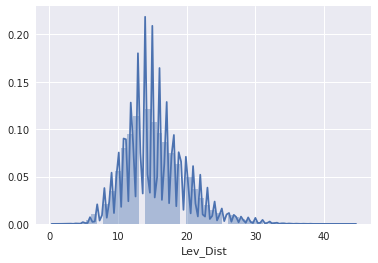

In [280]:
from scipy import stats, integrate
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
sns.distplot(Lev_df['Lev_Dist'])

In [289]:
# get density - distribution of levenshtein distance
#get distribution of og MeSH terms by term-depth level 
MeSH_map['split_count']=MeSH_map['MeSH_str'].apply(lambda row: len(row.split("."))) #get the nb of levels for every term

In [307]:
MeSH_map.columns

Index(['MeSH_desc', 'MeSH_str', 'split_count'], dtype='object')

In [291]:
og_MeSH_df=MeSH_map[MeSH_map['MeSH_desc'].isin(pmid_og_MeSH_list)]

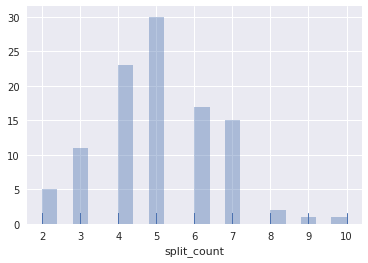

In [294]:
#plot distro 
sns.distplot(og_MeSH_df['split_count'], bins=20, kde=False, rug=True)



In [302]:
mas_5_levels=og_MeSH_df[og_MeSH_df['split_count']>6]

In [326]:
og_MeSH_df['MeSH_desc']

,MeSH_desc,MeSH_str,split_count
1828,HEK293 Cells,A11.251.210.172.750,5
2258,HEK293 Cells,A11.436.334,3
3545,Humans,B01.050.150.900.649.801.400.112.400.400,10
10571,Gout,C05.550.114.423,4
10599,Gout,C05.550.354.500,4
10781,Gout,C05.799.414,3
14984,Hypertension,C14.907.489,3
16417,Gout,C16.320.565.798.368,5
17603,Gout,C18.452.648.798.368,5
18554,Acute Disease,C23.550.291.125,4


In [296]:
mas_5_levels.columns

Index(['MeSH_desc', 'MeSH_str', 'split_count'], dtype='object')

In [303]:
MeSH_deep_terms=mas_5_levels['MeSH_desc'].tolist()

In [304]:
MeSH_deep_terms=list(set(MeSH_deep_terms))
len(MeSH_deep_terms)

11

In [305]:
mas_5_levels

['Losartan',
 'ATP Binding Cassette Transporter, Sub-Family G, Member 2',
 'Organic Cation Transport Proteins',
 'Organic Anion Transporters',
 'Risk Factors',
 'Logistic Models',
 'Uric Acid',
 'Aryl Hydrocarbon Hydroxylases',
 'Humans',
 'Mitoxantrone',
 'Cytochrome P-450 CYP2C9']

In [312]:
Lev_df.columns

Index(['Lev_Dist', 'og_MeSH_str', 'target_MeSH_str', 'og_MeSH_desc'], dtype='object')

In [321]:
import joypy
#get levenshtein distance for select descriptions

joyplt_df=Lev_df[Lev_df['og_MeSH_desc'].isin(MeSH_deep_terms)]

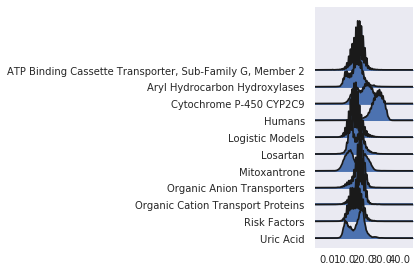

In [324]:
# Joy Plot of MeSH terms
fig, axes = joypy.joyplot(joyplt_df, by="og_MeSH_desc", column="Lev_Dist")

# Reduce the possible number of matches based on Levenshtein distance

In [337]:
# keep if edit distance is less than 6 in relation to the original list
new_MeSH_keepers_Lev=Lev_df[(Lev_df['Lev_Dist']<6) & (Lev_df['og_MeSH_desc'].isin(og_MeSH_df['MeSH_desc']))]

In [338]:
len(new_MeSH_keepers_Lev)
new_MeSH_keepers_Lev_list=new_MeSH_keepers_Lev['target_MeSH_desc'].tolist()

In [339]:
new_MeSH_keepers_Lev_list=list(set(new_MeSH_keepers_Lev_list))

In [340]:
len(new_MeSH_keepers_Lev_list)

5458

In [350]:
# how many overlap with the word2vec model
final_MeSH_term_list=list(set(w2v_MeSH_match_list)&set(new_MeSH_keepers_Lev_list))

In [351]:
len(final_MeSH_term_list)

312

In [352]:
final_MeSH_term_list

['Cytochrome P-450 Enzyme System',
 'Hemoglobins',
 'Pyrimidines',
 'Receptors, Cell Surface',
 'Principal Component Analysis',
 'Radiography',
 'Patient Compliance',
 'Clinical Trials as Topic',
 'Chelation Therapy',
 'Comorbidity',
 'Breath Tests',
 'Neoplasm Invasiveness',
 'Base Sequence',
 'Disease Models, Animal',
 'Haplotypes',
 'Radiation Dosage',
 'Glycoproteins',
 'Drug Resistance',
 'Organophosphonates',
 'Atrial Natriuretic Factor',
 'Albumins',
 'Lipopolysaccharides',
 'Pilot Projects',
 'Biological Availability',
 'Predictive Value of Tests',
 'Area Under Curve',
 'Arthritis, Rheumatoid',
 'Erythrocytes',
 'In Situ Hybridization',
 'Acute-Phase Proteins',
 'Gene Expression Regulation, Neoplastic',
 'Analgesics',
 'Heart Rate',
 'Cardiotonic Agents',
 'Genetic Markers',
 'Intercellular Adhesion Molecule-1',
 'Mutation',
 'Protein Binding',
 'Aminolevulinic Acid',
 'Drug Administration Schedule',
 'Carbon Monoxide',
 'Hematoma',
 'Postoperative Complications',
 'Sexual Beha

In [354]:
import csv

with open("Gout_MeSH_new_Query_terms.csv", 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(final_MeSH_term_list)

In [ ]:
#TODO: develop an inverse rank based simply upon how uncommon the terms are across the entire corpus of 10,000

# cluster the new terms with aglomerative clustering

In [360]:
# use word embeddings for only these MeSH terms
new_MeSH_w2v_features=df_w2v[df_w2v.index.isin(final_MeSH_term_list)]

In [363]:
new_MeSH_w2v_features.index[0]

'Adolescent'

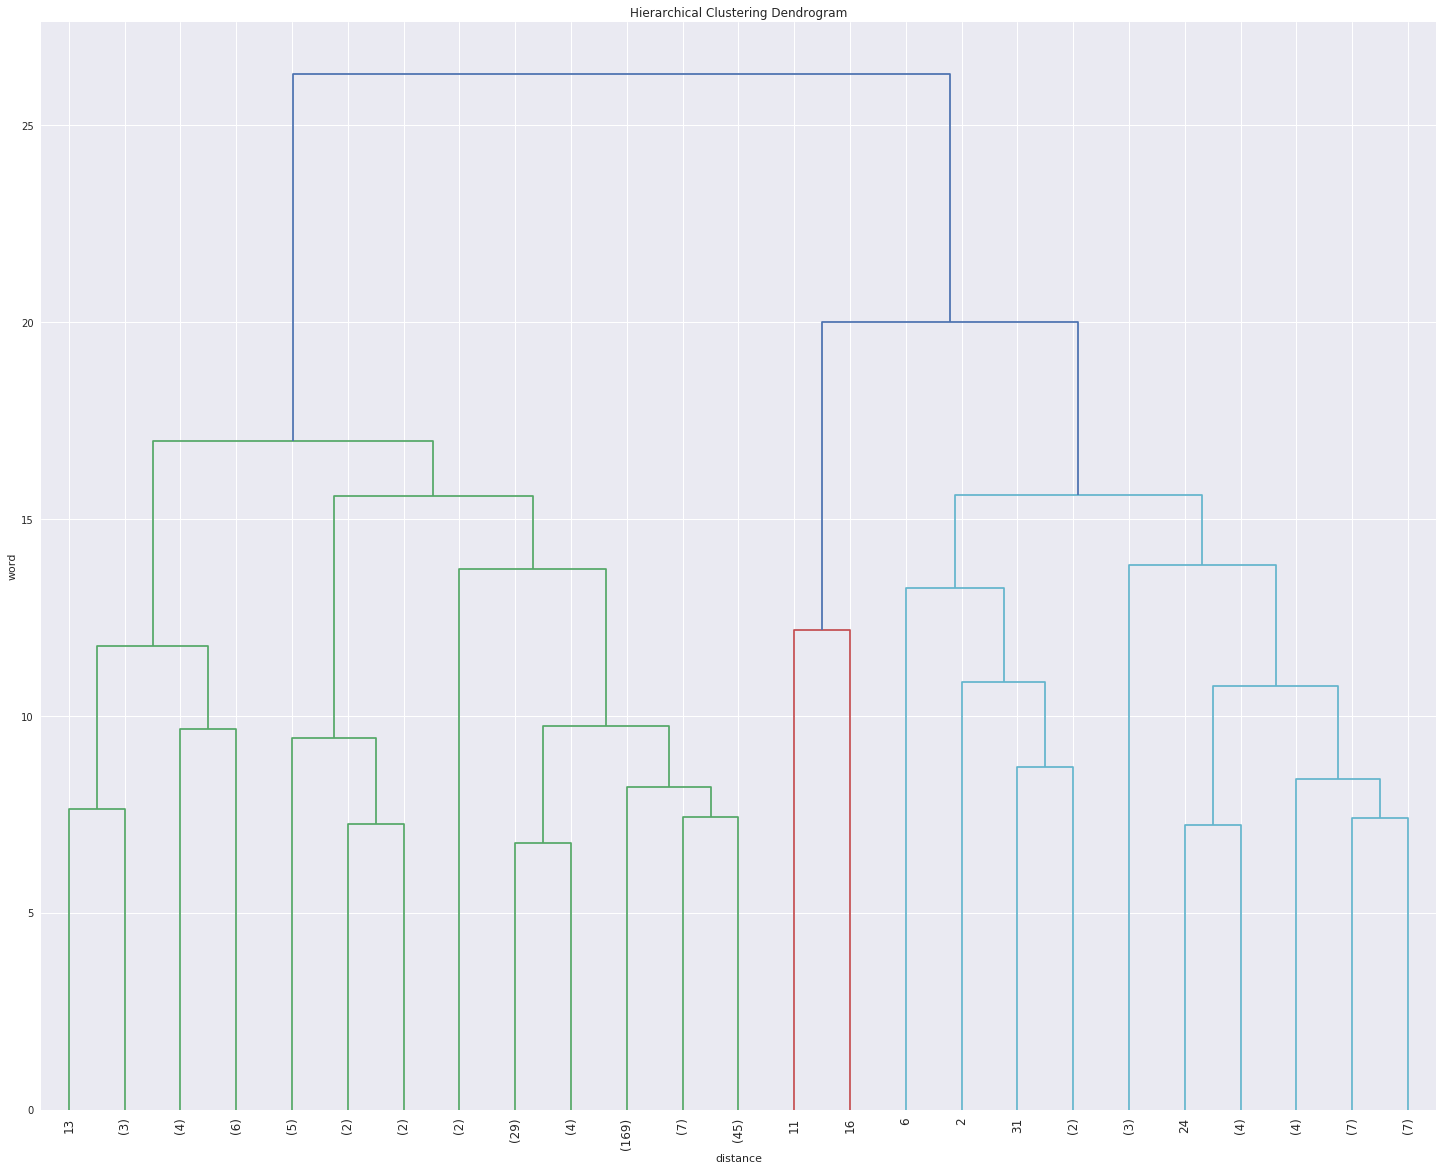

In [436]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
l = linkage(new_MeSH_w2v_features, method='complete', metric='seuclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 20))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # show only the last p merged clusters
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
#     orientation='left',
#     leaf_label_func=lambda v: str(new_MeSH_w2v_features.index[v]) #dont use with truncation?
)
plt.show()

In [398]:
len(l)

311

In [437]:
# Get the Clusters
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(l,20, criterion='maxclust')

In [438]:
unique, counts = np.unique(clusters, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  1   3]
 [  2   1]
 [  3   4]
 [  4   6]
 [  5   5]
 [  6   4]
 [  7   2]
 [  8  33]
 [  9 169]
 [ 10  52]
 [ 11   1]
 [ 12   1]
 [ 13   2]
 [ 14   1]
 [ 15   1]
 [ 16   1]
 [ 17   3]
 [ 18   5]
 [ 19   4]
 [ 20  14]]


In [418]:
new_MeSH_w2v_features.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,cluster_number
Adolescent,-0.037409,-1.486542,0.613295,2.037993,-2.153755,-2.689123,-1.603385,-3.027551,1.249184,-0.209130,...,-2.362039,1.626848,2.832362,-3.290244,1.321322,2.403687,3.819249,-1.533158,-0.796198,11
Creatinine,-0.893324,-2.521030,-0.090361,1.809352,-1.201389,-4.116233,0.104143,-2.063621,1.610046,-2.485948,...,-2.139379,1.092544,3.606871,-2.986740,0.230600,-0.858790,1.017725,0.397666,-1.381342,14
Child,-1.066581,-2.104739,0.812423,1.027421,-0.834015,-2.112537,-0.072263,-4.178267,0.599261,0.136970,...,-2.480747,1.101098,2.125319,-4.185073,0.889138,2.210013,3.378419,-1.354469,-0.266406,12
Prospective Studies,-2.753857,-2.278180,-0.422597,0.063427,1.693466,-2.020030,1.491740,-1.792905,-0.676284,-3.710871,...,-2.125946,0.364766,2.541056,-1.968980,-1.093978,-3.042697,-0.121223,-0.353654,-0.209042,5
Case-Control Studies,0.011977,-1.578586,0.053608,2.302725,-1.243010,-2.743119,-0.433467,-1.427025,1.086531,-1.150167,...,-1.393598,-0.024769,2.262213,-2.030639,0.686104,0.374748,1.905874,-0.898597,-0.319277,16


In [419]:
new_MeSH_w2v_features.to_csv("w2v_MeSH_clusters.csv")

# T-SNE plot

In [439]:
new_MeSH_w2v_features.drop(['cluster_number'], axis=1, inplace=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [441]:
from sklearn.manifold import TSNE
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(new_MeSH_w2v_features)

In [444]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
labels=new_MeSH_w2v_features.index

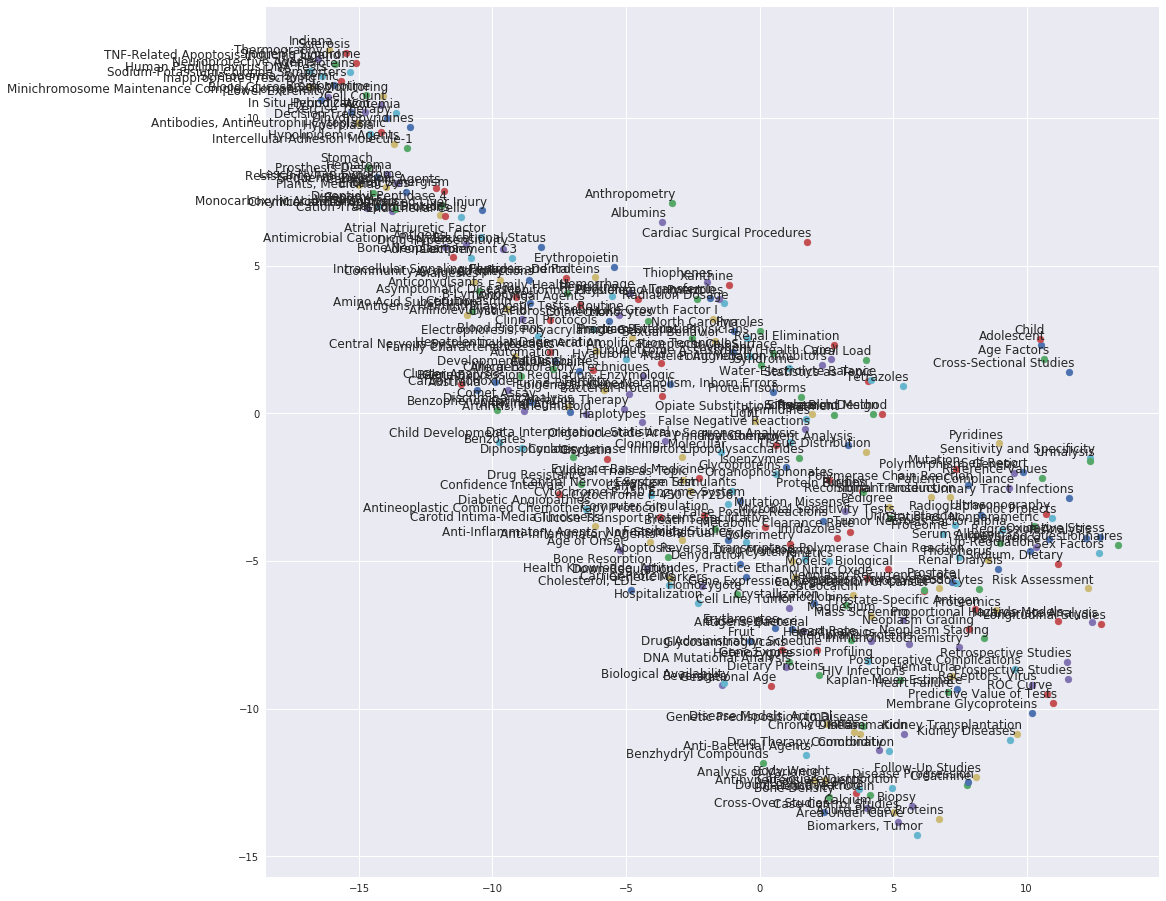

In [445]:
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [447]:
Matched_docs.columns

Index(['Title', 'Abstract', 'MeSH_Descriptor', 'MeSH_Qualifier', 'Total_Text',
       'Clean_Text'],
      dtype='object')

In [465]:
#  restrict to the 100 most common MeSH terms within our returned corpus 
# return freq counts for our 300+ terms within the 204 new articles
returned_MeSH_vocab=Matched_docs['MeSH_Descriptor'].tolist()
returned_MeSH_vocab=[el for sublist in  returned_MeSH_vocab for el in sublist ] #flatten
returned_MeSH_vocab=[el for el in returned_MeSH_vocab if el] # drop empties

In [467]:
# subset to only words in final MeSH list
returned_MeSH_vocab_final_subset=[el for el in returned_MeSH_vocab if el in new_MeSH_w2v_features.index ]

In [470]:
len(returned_MeSH_vocab)

1237

['Adenine',
 'Administration, Oral',
 'Animals',
 'Benzbromarone',
 'Creatinine',
 'Drug Synergism',
 'Drugs, Chinese Herbal',
 'Hyperuricemia',
 'Kidney',
 'Male',
 'Organic Anion Transport Protein 1',
 'Organic Anion Transporters, Sodium-Independent',
 'Oxonic Acid',
 'Plant Exudates',
 'Rats',
 'Rats, Sprague-Dawley',
 'Uric Acid',
 'Xanthine Oxidase',
 'Animals',
 'Cell Line',
 'Gene Expression Regulation',
 'Heart Atria',
 'Hyperuricemia',
 'Kv1.5 Potassium Channel',
 'MAP Kinase Signaling System',
 'Mice',
 'Muscle Proteins',
 'Myocytes, Cardiac',
 'Oxidative Stress',
 'Phosphorylation',
 'Uric Acid',
 'Aged, 80 and over',
 'Drug Hypersensitivity Syndrome',
 'Eosinophilia',
 'Febuxostat',
 'Gout',
 'Humans',
 'Male',
 'Animals',
 'Anthocyanins',
 'Glucose Transport Proteins, Facilitative',
 'Humans',
 'Hyperuricemia',
 'Ipomoea batatas',
 'Kidney',
 'Male',
 'Mice',
 'Organic Anion Transport Protein 1',
 'Organic Anion Transporters',
 'Plant Extracts',
 'Uric Acid',
 'Xanthine Ox

In [454]:
returned_MeSH_vocab_final_subset

[]

In [471]:
# get the most common terms for better T-SNE visualization
from collections import Counter
w_counts=Counter(returned_MeSH_vocab_final_subset)

In [476]:
w_counts_most_common=w_counts.most_common(100)
type(w_counts)# export
with open("MeSH_term_count_of_returned.txt") as f:
    for k,v in  c.w_counts:
        f.write( "{} {}\n".format(k,v) )

collections.Counter

In [482]:
with open("MeSH_term_count_of_returned.txt", encoding='utf-8-sig', mode='w') as f:
    for k,v in  w_counts.items():
        f.write( "{} {}\n".format(k,v) )

In [485]:
w_counts_most_common_list=[]
for x,_ in w_counts_most_common:
    w_counts_most_common_list.append(x)

In [487]:
# now subset our word 2vec list
subsetted_w2v_MeSH_list=new_MeSH_w2v_features[new_MeSH_w2v_features.index.isin(w_counts_most_common_list)]

In [489]:
subsetted_w2v_MeSH_list

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Adolescent,-0.037409,-1.486542,0.613295,2.037993,-2.153755,-2.689123,-1.603385,-3.027551,1.249184,-0.209130,-0.524561,-2.362039,1.626848,2.832362,-3.290244,1.321322,2.403687,3.819249,-1.533158,-0.796198
Creatinine,-0.893324,-2.521030,-0.090361,1.809352,-1.201389,-4.116233,0.104143,-2.063621,1.610046,-2.485948,-0.275176,-2.139379,1.092544,3.606871,-2.986740,0.230600,-0.858790,1.017725,0.397666,-1.381342
Child,-1.066581,-2.104739,0.812423,1.027421,-0.834015,-2.112537,-0.072263,-4.178267,0.599261,0.136970,1.094635,-2.480747,1.101098,2.125319,-4.185073,0.889138,2.210013,3.378419,-1.354469,-0.266406
Prospective Studies,-2.753857,-2.278180,-0.422597,0.063427,1.693466,-2.020030,1.491740,-1.792905,-0.676284,-3.710871,1.336438,-2.125946,0.364766,2.541056,-1.968980,-1.093978,-3.042697,-0.121223,-0.353654,-0.209042
Case-Control Studies,0.011977,-1.578586,0.053608,2.302725,-1.243010,-2.743119,-0.433467,-1.427025,1.086531,-1.150167,-0.149015,-1.393598,-0.024769,2.262213,-2.030639,0.686104,0.374748,1.905874,-0.898597,-0.319277
Sensitivity and Specificity,-0.482501,0.024901,0.027251,0.362788,0.517500,0.632100,1.567862,-0.928746,-2.038938,-2.702502,0.914842,0.354890,-2.213443,-0.021396,-0.088007,-0.236626,-3.537757,0.615995,-2.971658,-0.210078
Cross-Sectional Studies,-1.984035,-1.444760,0.162943,0.196385,-0.827066,-2.489643,-1.677025,-2.494303,0.013014,-0.906157,-1.206354,-2.877648,3.001942,3.115458,-3.575576,-1.068347,0.778375,2.024313,0.103484,-1.703864
Predictive Value of Tests,-1.630825,-2.373547,-0.395140,1.268136,1.299405,-2.737170,1.791669,-1.326081,-0.221352,-4.183150,1.666874,-1.560110,-0.721191,2.756119,-1.658111,-0.582752,-3.932107,-0.174041,-0.530335,-0.047910
Retrospective Studies,-2.045043,-1.436596,-0.605692,0.014240,1.277502,-0.860033,1.725374,-1.775712,-1.190547,-3.415616,1.161282,-1.406368,0.105454,2.248475,-1.173122,-1.071195,-3.567518,-0.218014,-0.833916,-0.162598
Follow-Up Studies,-1.202485,-2.433999,-0.237284,1.653733,-0.102390,-3.571438,-0.070185,-1.735723,0.863350,-2.495457,0.287132,-2.244553,1.119577,3.331893,-2.589221,-0.539335,-1.383272,0.873832,0.368714,-0.853101


# T- SNE Take 2 

In [490]:
subsetted_w2v_MeSH_list.to_csv("w2v_MeSH_top85_terms_w_features.csv")

In [491]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(subsetted_w2v_MeSH_list)

In [492]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
labels=subsetted_w2v_MeSH_list.index

# Evaluation